In [202]:
import numpy as np
import pandas as pd
import time
import multiprocessing as mp
import itertools
from astropy.table import hstack, Table
from astropy.io import fits
import astropy.units as u
from pyarrow import parquet
from astropy.coordinates import SkyCoord, Distance
import scipy.interpolate as interp

import os
import sys
import signal
from matplotlib import pyplot as plt

import SPHEREx_ObsSimulator as SPobs
from SPHEREx_Simulator_Tools import SPHEREx_Logger, data_filename
import SPHEREx_InstrumentSimulator as SPinst
import SPHEREx_SkySimulator as SPsky
from spherex_parameters import load_spherex_parameters
from SPHEREx_SkySimulator import QuickCatalog, Catalog_to_Simulate


# survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/spherex_survey_plan_R2.fits" # on local machine
survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/survey_plan/spherex_survey_plan_R3_trunc3month.fits"
SPHEREx_Pointings = SPobs.Pointings(input_file = survey_plan_file,
                                   Gaussian_jitter=0., 
                                   roll_angle='psi2')

# Load instrument and project parameters as a dictionary
spherex_parameters = load_spherex_parameters()

# Scene = SPsky.Scene(SPHEREx_Pointings,
#                          zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())
#                    dgl_model =SPsky.DGLCalculator(Logger=Logger), Logger=Logger)
Scene = SPsky.Scene(SPHEREx_Pointings, 
                    zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())
                        # zodi_model=SPsky.zodicalc.SkyAveragedZodi(filepath='/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx_2023/Codes/intensity_mapper_v30.csv'))

SPHEREx_Instrument = SPinst.Instrument(
    instrument_data=spherex_parameters,
    psf=data_filename("psf/simulated_PSF_database_centered_v3_og.fits"),
    psf_downsample_by_array={1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4},
    psf_trim_by_array={1: 32, 2: 32, 3: 32, 4: 32, 5: 32, 6: 32},
    noise_model=SPinst.white_noise,
    dark_current_model=SPinst.poisson_dark_current,
    lvf_model=SPinst.Tabular_Bandpass()
)

Channels = Table.read(data_filename('Channel_Definition_03022021.fits'))


### Set up some directories
primary_dir = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/blended_QC/"
file_inter = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/blended_QC/"

def find_sed_fits_file_corrected(index, tractorID):
    if index < 60000:
        #print("0 - 60000")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/0_60000/"
    elif index < 120000:
        #print("60000 - 120000")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/60000_120000/"
    else:
        #print("120000 - ")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/120000_166041/"
    
    filename = DIR + f"cosmos2020_hiresSED_FarmerID_{tractorID:07d}_corrected.fits"
    return filename

def calc_source_separation(RA, DEC):
    """
    RA, DEC = numpy arrays of ra, dec
    
    calculates the distance to nearest neighbors for given sources
    
    """
    nearest_distances = []
    coords = SkyCoord(ra=RA * u.deg, dec=DEC * u.deg, frame='icrs')

    # calculate the angular separation to find nearest neighbors
    for ii, coord in enumerate(coords):
        separations = coord.separation(coords)
        separations[ii] = np.inf

        # find the minimum separation, which is the nearest neighbor
        nearest_distance = np.min(separations).to("arcsec").value
        nearest_distances.append(nearest_distance)

    nearest_distances = np.array(nearest_distances)
    
    return nearest_distances

# og 

with fits.open('../../../../SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits') as fits_data:
    cosmos = Table(fits_data[1].data)

# test sampling 

In [203]:

COSMOS_tab = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/refcat_cuts/COSMOS2020_SPHEXrefcat_v0.6_166k_matched_Jean8k.csv")
ra_colname = "ra"
dec_colname = "dec"

# idx_refcat = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/source_selection/cosmos166k_posmatch_boolarray.txt", dtype=bool)
idx_refcat = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/refcat_cuts/boolean_cut_0.8.txt", 
                        dtype=bool, skiprows=2)
match = COSMOS_tab['match'] == 'True'
xmatch = COSMOS_tab['xmatched_LS_110k']==1
cosmology = COSMOS_tab['COSMOLOGY']==1


## start testing QC + Tractor
i = 1526
# i = 1346
ra = COSMOS_tab[ra_colname][idx_refcat & match][i]
dec = COSMOS_tab[dec_colname][idx_refcat & match][i]

tractorID = COSMOS_tab['Tractor_ID'][idx_refcat & match][i]
source_ID = np.where(COSMOS_tab["Tractor_ID"] == tractorID)[0][0] # index among 166k

# find input hires sed
sed_path = find_sed_fits_file_corrected(source_ID, tractorID)

print(f"    tractor ID for {i} = ", tractorID, " sed file ", sed_path)


## add nearby photometered sources (< 4 SPHEREx pixels)
size = 4 * 6.2 / 3600 # deg 
idx_close = np.where((COSMOS_tab[ra_colname][idx_refcat & xmatch] <= (ra+size)) &
                     (COSMOS_tab[ra_colname][idx_refcat & xmatch] >= (ra-size)) &
                     (COSMOS_tab[dec_colname][idx_refcat & xmatch] <= (dec+size)) &
                     (COSMOS_tab[dec_colname][idx_refcat & xmatch] >= (dec-size)))[0]
print("   Number of nearby photometered sources  = ", len(idx_close))

## calculate distance to the nearest neighbor
sep = calc_source_separation(COSMOS_tab['ra'][idx_refcat&xmatch][idx_close], COSMOS_tab['dec'][idx_refcat&xmatch][idx_close])
print('smallest separation = ', np.nanmin(sep), ' arcsec')


    tractor ID for 1526 =  233861  sed file  /Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/0_60000/cosmos2020_hiresSED_FarmerID_0233861_corrected.fits
   Number of nearby photometered sources  =  10
smallest separation =  6.686634942661105  arcsec


N srcs (< full_sky ) =  5751
N srcs (< full_sky & > deep_cut ) =  4687


/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_1443/3814831104.py:16: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux_Jy / 3631)
/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_1443/3814831104.py:16: RuntimeWarning: divide by zero encountered in log10
  mag = -2.5 * np.log10(flux_Jy / 3631)


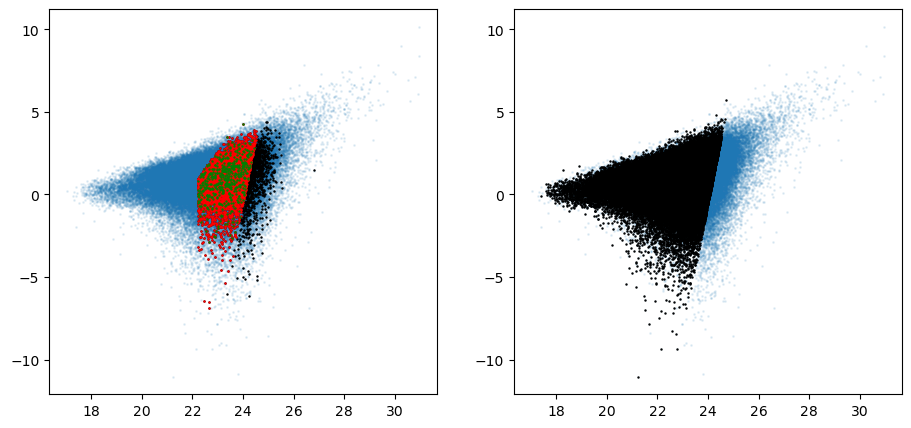

In [204]:
## plot, check refcat selection
match = COSMOS_tab['match'] == 'True'
N_sources = 500

# randomly select N sources from the pool match & (~cosmology) & idx_refcat
rand_ids = np.random.randint(low=0,
                             high=len(COSMOS_tab[match & (~cosmology) & idx_refcat]),
                             size=N_sources)

# given start index, select N sources in order, from match & (~cosmology) & idx_refcat
id_start = 500
rand_ids = np.arange(id_start, N_sources+id_start)


def get_mag_from_flux(flux_Jy):
    mag = -2.5 * np.log10(flux_Jy / 3631)
    return mag

mag_w1 = get_mag_from_flux(COSMOS_tab['LS_W1'] / 1e6)
mag_z  = get_mag_from_flux(COSMOS_tab['LS_z']  / 1e6)

# full sky:
cosmology = (COSMOS_tab['COSMOLOGY']==1)

fig = plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.scatter(mag_z, mag_z - mag_w1, s=1, alpha=0.1)
plt.scatter(mag_z[match & (~cosmology)], 
            mag_z[match & (~cosmology)] - mag_w1[match & (~cosmology)], 
            s=0.5, color='black')

print("N srcs (< full_sky ) = ", len(COSMOS_tab[match & (~cosmology)]))
print("N srcs (< full_sky & > deep_cut ) = ", len(COSMOS_tab[match & (~cosmology) & idx_refcat]))

plt.scatter(mag_z[match & (~cosmology) & idx_refcat], 
            mag_z[match & (~cosmology) & idx_refcat] - mag_w1[match & (~cosmology) & idx_refcat], 
            s=0.5, color='red')

plt.scatter(mag_z[match & (~cosmology) & idx_refcat][rand_ids], 
            mag_z[match & (~cosmology) & idx_refcat][rand_ids] - mag_w1[match & (~cosmology) & idx_refcat][rand_ids], 
            s=0.5, color='green')

# plt.scatter(mag_z[idx_refcat&xmatch][idx_close], mag_z[idx_refcat&xmatch][idx_close] - mag_w1[idx_refcat&xmatch][idx_close], s=10, color='green')

## nearby photometerd sources pool
plt.subplot(1,2,2)
plt.scatter(mag_z, mag_z - mag_w1, s=1, alpha=0.1)

plt.scatter(mag_z[idx_refcat & xmatch], 
            mag_z[idx_refcat & xmatch] - mag_w1[idx_refcat & xmatch], 
            s=0.5, color='black')



# primary vs secondary photometry & truth flux binning

In [67]:

# initialize QuickCatalog, only forced photometry, no Tractor
QC = QuickCatalog(SPHEREx_Pointings, SPHEREx_Instrument, Scene, spectral_channel_table=Channels, \
                  Use_Tractor=False, \
                  subpixel_offset_x=0, subpixel_offset_y=0)

Sources_to_Simulate = Catalog_to_Simulate()

Sources_to_Simulate.load_single(name='COSMOS_{}'.format(tractorID),
                                ra=ra*u.deg, 
                                dec=dec*u.deg,
                                inputpath=sed_path, 
                                no_phot='yes')


## add into QC to photometer
# ii = 0
# for idx in idx_close:
#     print(ii)

#     if COSMOS_tab['Tractor_ID'][idx_refcat&cosmology][idx] == tractorID:
#         # skip the primary central source itself
#         continue
        
# #     if ii > 1:
# #         print(ii, "break")
# #         break

#     ra_this = COSMOS_tab[ra_colname][idx_refcat&cosmology][idx]
#     dec_this = COSMOS_tab[dec_colname][idx_refcat&cosmology][idx]
#     tractorID_this = COSMOS_tab['Tractor_ID'][idx_refcat&cosmology][idx]
#     source_ID_this = np.where(COSMOS_tab["Tractor_ID"] == tractorID_this)[0][0] # index among 166k

#     sed_this = find_sed_fits_file_corrected(source_ID_this, tractorID_this)
#     print("   tractor ID ", tractorID_this, "sed file ", sed_this)
#     Sources_to_Simulate.load_single(name='COSMOS_{}'.format(tractorID_this),
#                                     ra=ra_this*u.deg, 
#                                     dec=dec_this*u.deg,
#                                     inputpath=sed_this)
    
#     ii += 1

print("photometry with QC...")
# photometry
SPHEREx_Catalog_2yr, Truth_Catalog_2yr = QC(Sources_to_Simulate) 
print("Done QC")

id_primary = SPHEREx_Catalog_2yr['SOURCE_ID'] == f'COSMOS_{tractorID}'


### save primary photometry
SPsky.save_level3_primary(SPHEREx_Catalog_2yr[id_primary], '../data/primary_phot_id{}_2yr.parq'.format(tractorID))


### calculate secondary photometry
SPsky.save_level3_secondary(SPHEREx_Catalog_2yr[id_primary], 
                            Channels, 
                            SPHEREx_Instrument, 
                            '../data/secondary_phot_id{}_2yr.parq'.format(tractorID), 
                            pointing_table=SPHEREx_Pointings.pointing_table, 
                            fluxerr_from_weights=True)


photometry with QC...
Done QC


../data/primary_phot_id233861_2yr.parq
../data/secondary_phot_id233861_2yr.parq


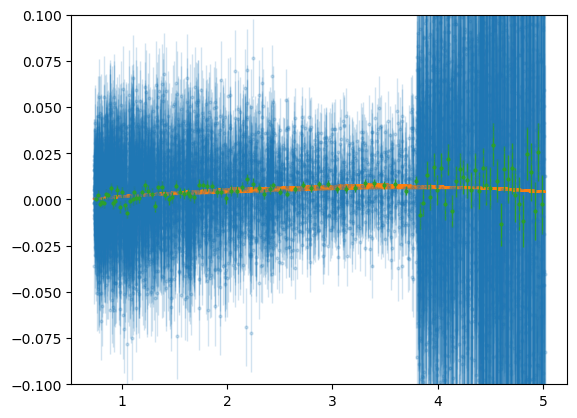

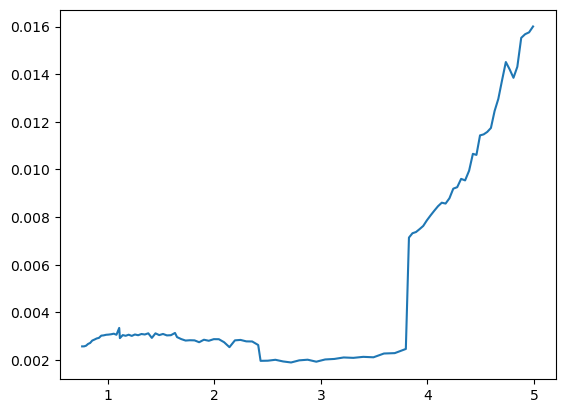

In [204]:
file = "../data/primary_phot_id{}_2yr.parq".format(tractorID)
print(file)
prim = Table.read(file)

file = '../data/secondary_phot_id{}_2yr.parq'.format(tractorID)
print(file)
secd = Table.read(file)

## plot photometry
plt.errorbar(prim['lambda'][0], prim['flux'][0]/1000, yerr=prim['flux_err'][0]/1000, fmt='o', ms=2, lw=1, alpha=0.2)
plt.plot(SPHEREx_Catalog_2yr['WAVELENGTH'], Truth_Catalog_2yr['Flux'])

plt.errorbar(secd['lambda'][0], secd['flux_deepfield'][0]/1000, yerr=secd['flux_err_deepfield'][0]/1000, fmt='o', ms=2, lw=1)
plt.ylim(-0.1, 0.1)

plt.show()

plt.plot(secd['lambda'][0], secd['flux_err_deepfield'][0]/1000)



In [91]:
from pathlib import Path
import pyarrow as pa
from pyarrow import parquet
import numpy as np
from astropy.io import fits, ascii
import astropy.units as u

def make_spherex_fiducial_filters(
    spectral_cal,
    output_path,
    nfilters=306
):
    
    """Generate and save fiducial filters at the central wavelength of a pre-defined number
    of SPHEREx channels to be used for photometric redshift fitting.

    Version 1.0, February 13, 2024

    Args:
        spectral_cal (~astropy.Table): The calibration file giving SPHEREx pixels to transmission.
        output_path (string): The path to write the
            output files. The transmission profiles and a file listing them are written to the specified
            output folder. 
        nfilters (int): Number of fiducial filters to use for fitting. Default=306.

    Returns:
        None
        
    Note: currently not implemented while we wait to see an example of spectral_cal
    """

    
def average_L3_photometry_on_fiducial_grid_truth(
    l3_catalog,
    fiducial_filter_dir,
    fiducial_filter_list,
    centwavefilename,
    outputfile,
    return_output=False
):
    
    """Average L3 SPHEREx photometry onto regular filter grid for photo-z fitting. 

    Version 1.1, May 21, 2024

    Args:
        (L3_phot_tbl = parquet.read_table(L3_photometry_file)
        l3_catalog = L3_phot_tbl.to_pandas())
        
        L3_photometry_file (Parquet): The L3 formatted Parquet file with native SPHEREx measurements.
        fiducial_filter_dir: Path to the directory containing the fiducial filter transmission curves
        fiducial_filter_list: File containing the names of the fiducial SPHEREx filters to use, representing
                each channel. Should be the same list provided for photo-z fitting (modulo external photometry).
        centwavefilename: Location to store the central wavelengths corresponding to averaged photometry.
        outputfile: Location to store the resulting file of averaged SPHEREx photometry for fitting.

    Returns:
        Default to None. If return_output=True, returns Pandas dataframe with the output.
    """

    import pandas as pd

    # ensure the filter dir is a Path object
    fiducial_filter_dir = Path(fiducial_filter_dir)
    fiducial_filter_file = fiducial_filter_dir / fiducial_filter_list

    #Read in the fiducial filter profiles
    filtnames = pd.read_csv(fiducial_filter_file, header=None).values
        
    cwave = [] #Compute and hold central wavelengths of the filters we are averaging onto
    detnum = [] #Array number for each transmission curve
    filter_wvarray = [[]] #Hold the curves for computing spectral weighting
    filter_trarray = [[]]
    
    cnt=0
    for filtname in filtnames:
        filt_file = fiducial_filter_dir / filtname[0]
        f = np.loadtxt(filt_file)
        thiswv = f[:,0]/1.e4
        thistr = f[:,1]
        cwave.append(np.sum(thiswv*thistr)/np.sum(thistr))
        
        #Get the array number for each filter. Assumes the string "det"+array_num exists in filename
        print('filtname ', filtname[0])
        detnum.append(int(filtname[0].split("band")[1][0]))
        if cnt==0:
            filter_wvarray[0] = thiswv
            filter_trarray[0] = thistr
        else:
            filter_wvarray.append(thiswv)
            filter_trarray.append(thistr)
        cnt+=1

    arraynum = np.array(detnum)
    centwave = np.array(cwave)

    #Write the centwave file for reference
    np.savetxt(centwavefilename,centwave)
    
    
    #Go through each source in L3 input catalog and compute averaged SPHEREx photometry
    output_data = [[]]
    for i in range(len(l3_catalog)): 
        
        #Get the L3 measurements
        waves=l3_catalog.iloc[i]['lambda']
        fluxes = l3_catalog.iloc[i]['flux']
        fluxerrs = l3_catalog.iloc[i]['flux_err']
        detids = l3_catalog.iloc[i]['det_id']
        
        #Initialize arrays to hold average fluxes in each channel
        fluxarr = [[]]
        errarr = [[]]
        spectralweightarr = [[]]
        fluxarr[0] = []
        errarr[0] = []
        spectralweightarr[0] = []
        for w in range(len(centwave)-1):
            fluxarr.append([])
            errarr.append([])
            spectralweightarr.append([])
  
        #Assign measured fluxes to appropriate fiducial wavelengths
        for j in range(len(fluxes)):
            thiswave = waves[j]
            thisdet = detids[j]
            
            #Only check wavelength against those profiles on same array as measurement
            arrayidcs = np.where(arraynum==thisdet)[0]
            ix = np.argmin(np.abs(thiswave-centwave[arrayidcs]))
            filtidx = arrayidcs[ix]
            
            fluxarr[filtidx].append(fluxes[j])
            errarr[filtidx].append(fluxerrs[j])
            widx = np.argmin(np.abs(thiswave-filter_wvarray[filtidx]))
            spectralweightarr[filtidx].append(filter_trarray[filtidx][widx]/np.max(filter_trarray[filtidx]))
                      
        #Compute the averaged fluxes at each band center
        fiducial_flux = []
        fiducial_error = []
        for k in range(len(centwave)):
            flux = np.array(fluxarr[k])
            err = np.array(errarr[k])
            weight = np.array(np.power(spectralweightarr[k],2) / np.power(errarr[k],2))
            #np.average(flux[inchannel], weights=weight[inchannel])
            if len(flux > 0):
                fiducial_flux.append(np.sum(flux * weight) / np.sum(weight))
                fiducial_error.append(np.sqrt(1/(np.sum(np.power(err,-2)))))    
            else:
                fiducial_flux.append(0.)
                fiducial_error.append(5.e4) #huge error on unconstrained channel           
        
        if i==0:
            output_data[0] = [l3_catalog.iloc[i]['source_id'], 0., 0.,
                            np.array(fiducial_flux), np.array(fiducial_error)]
        else:
            output_data.append([l3_catalog.iloc[i]['source_id'], 0., 0.,
                            np.array(fiducial_flux), np.array(fiducial_error)])
   

    columns = ['source_id', 'x', 'y', 'fiducial_flux', 'fiducial_error']
    df = pd.DataFrame(data=output_data, columns=columns)
    
    #Write the output to file
    f = open(outputfile,'w')
    for i in range(len(df)):

        f.write("%d" % df.iloc[i]['source_id'])
        f.write(" ")
        f.write("%.1f" % 0.0)
        f.write(" ")
        f.write("%.1f" % 0.0)
        f.write(" ")

        for j in range(len(df["fiducial_flux"].iloc[i])):

            f.write(np.format_float_positional(np.float32(df.iloc[i]['fiducial_flux'][j])))
            f.write(" ")
            f.write(np.format_float_positional(np.float32(df.iloc[i]['fiducial_error'][j])))
            f.write(" ")
            
        f.write("\n")
    f.close()
        
    if return_output:    
        return df
    else: 
        return None

In [15]:
from scipy import interpolate

def save_level3_secondary_truth(
    Primary_Catalog,
    Channels_In,
    Instrument,
    output_path,
    method="mean",
    pointing_table=None,
    source_id_lookup=None,
    external_survey_lookup=None,
    external_source_id_lookup=None,
    spherex_class_lookup=None,
    pm_ra=None,
    pm_dec=None,
    parallax=None,
    fluxerr_from_weights=False,
):
    """Save `QuickCatalog` output to parquet (secondary All Sky Catalog)

    Notes
    -----
    This function saves a catalog generated by
    `~SPHEREx_SkySimulator.quickcatalog.QuickCatalog` or
    `~SPHEREx_SkySimulator.quicker_catalog.QuickerCatalog` so that it looks
    like a secondary All Sky Catalog in a parquet file in the format specified in
    "SSDC Data Product Specification: Level 3 All-Sky Catalog" Version 1.0
    February 13, 2023

    The secondary All Sky Catalog contains spectra for each source that are
    rebinned in a common spectral grid.

    Parameters
    ----------
    Primary_Catalog : `~astropy.Table`
        A table object containing the catalog data.

    Channels_In : `~astropy.Table`
        A table objecting containing the definition of the spectral channels.
        The table must contain column names `Channel`, `lambda_min`,
        `lambda_max`, and `band`.
        If `Channels_In` is set to None; a spectral channel table will be
        read from the Instrument.

    Instrument : `~SPHEREx_InstrumentSimulator.Instrument`
        The instrument model; in particular this uses the `pixel_to_band()`
        method, or optionally the `Spectral_Channels` attribute.

    output_path : str or None
        The path and filename to write the output parquet file.
        If `None`, the function will return the pyarrow table.

    method : str
        The method used to average the measurements within a spectral channel.
        Can be one of "mean", "spline", "poly".
        The default is "mean".

    pointing_table : `~astropy.Table`, optional
        Survey plan used to generate the catalog.
        Default is `None`.

    source_id_lookup : dict, optional
        A dictionary that provides a translation between the ``"SOURCE_ID"``
        field produced by `~SPHEREx_SkySimulator.quickcatalog.QuickCatalog` and
        the output ``"source_id"``.
        Default is `None`.

    external_survey_lookup : dict, optional
        A dictionary that provides a translation between the ``"SOURCE_ID"``
        field produced by `~SPHEREx_SkySimulator.quickcatalog.QuickCatalog` and
        the output ``"external_survey"``.
        Default is `None`.

    spherex_class_lookup : dict, optional
        A dictionary that provides a translation between the ``"SOURCE_ID"``
        field produced by `~SPHEREx_SkySimulator.quickcatalog.QuickCatalog` and
        the output ``"spherex_class"``.
        Default is `None`.

        .. note::
            ``"spherex_class"`` is a bitwise flag with information about what
            the source is used for by the pipeline. ::

                    Bit Name
                    0 ASTROMETRIC
                    1 PSF
                    2 PHOTOMETRIC
                    3 CALSPEC
                    4 BRIGHT
                    5 COSMOLOGY
                    6 ICES
    pm_ra, pm_dec, parallax : float, array-like, optional
        Proper motion (ra and dec) and parallax data to include in the output
        file.
        Default is `None`.

    fluxerr_from_weights : bool, optional
        If `True`, compute flux error by combining weights.  Otherwise,
        use the standard deviation of the mean of measurements within each bin.
        Default is False.

    Returns:
        None
    """
    if method not in ["mean", "spline", "poly"]:
        raise ValueError(f"Unsupported interpolated method: {method}")

    if Channels_In is not None:
        Channels = Channels_In
    else:
        Channels = Instrument.Spectral_Channels

    # set up synthetic bands
    synbands = [
        "F784",
        "LSST_y",
        "LSST_z",
        "2MASS_J",
        "2MASS_H",
        "2MASS_Ks",
        "WISE_W1",
        "WISE_W2",
    ]
    synband_interpolator = {}
    for synband in synbands:
        T = Table.read(
            data_filename(
                f"data/synflux_bands/{synband}.ecsv", package="SPHEREx_SkySimulator"
            )
        )
        synband_interpolator[synband] = interpolate.interp1d(
            T["wl"].data, T["t"].data, fill_value=0.0, bounds_error=False
        )

    # Define lists of types for parquet library
    lfloat32 = pa.list_(pa.float32())
    lbool = pa.list_(pa.bool_())
    lint64 = pa.list_(pa.int64())

    #
    # the scheme for the parquet file output.
    # the tuple items are name, parquet data type, units, description
    #

    pa_flds_info = [
        ("source_id", pa.int64(), None, "Unique SPHEREx ID"),
        ("external_survey", pa.int8(), None, "Identifier of external survey"),
        (
            "external_source_id",
            pa.int64(),
            None,
            "ID of source in external_survey catalog",
        ),
        ("spherex_class", pa.int32(), None, "Source origin in reference catalog"),
        ("ra", pa.float64(), u.deg, "R.A. (from reference catalog)"),
        ("dec", pa.float64(), u.deg, "Decl. (from reference catalog)"),
        (
            "pm_ra",
            pa.float32(),
            u.mas / u.yr,
            "Proper motion in R.A. (from reference catalog)",
        ),
        (
            "pm_dec",
            pa.float32(),
            u.mas / u.yr,
            "Proper motion in Decl. (from reference catalog)",
        ),
        ("parallax", pa.float32(), u.mas, "Parallax (from reference catalog)"),
        ("lambda", lfloat32, u.micron, "Fixed wavelength grid"),
        (
            "flux_allsky",
            lfloat32,
            u.uJy,
            "Derived flux at each interpolated wavelength.  Obtained from the AllSky survey tiles.",
        ),
        (
            "flux_err_allsky",
            lfloat32,
            u.uJy,
            "Derived flux uncertainty at each interpolated wavelength.  Obtained from the AllSky survey tiles.",
        ),
        (
            "flux_deepfield",
            lfloat32,
            u.uJy,
            "Derived flux at each interpolated wavelength.  Obtained from Deep Fields survey tiles.",
        ),
        (
            "flux_err_deepfield",
            lfloat32,
            u.uJy,
            "Derived flux uncertainty at each interpolated wavelength.  Obtained from Deep Fields survey tiles.",
        ),
        ("ext_flg", pa.bool_(), None, "True if treated as extended source"),
        (
            "unobs_flg_allsky",
            lbool,
            None,
            "Flag indicating if the source was not observed at a given interpolated wavelength.",
        ),
        (
            "unobs_flg_deepfield",
            lbool,
            None,
            "Flag indicating if the source was not observed at a given interpolated wavelength.",
        ),
        ("ql_fl", lint64, None, "Quality flag for the derived flux."),
        ("nyquist_comp", pa.float32(), None, "Nyquist completeness"),
        (
            "synflux",
            lfloat32,
            u.uJy,
            "Measured flux in F784, Rubin z and Y, 2MASS J, H, and Ks, and WISE W1 and W2 bands.",
        ),
        (
            "synflux_err",
            lfloat32,
            u.uJy,
            "Measured flux error in F784, Rubin z and Y, 2MASS J, H, and Ks, and WISE W1 and W2 bands.",
        ),
        ("var_flag", lbool, None, "Flag for variable sources."),
        (
            "var_ext_bright",
            lfloat32,
            None,
            "Additional flag for bright variable sources: contains sigma of variability N=102.",
        ),
        (
            "var_ext_faint",
            lfloat32,
            None,
            "Additional flag for faint variable sources: contains sigma of variability in synthetic bands.",
        ),
    ]

    pa_units = {}
    for t in pa_flds_info:
        pa_units[t[0]] = t[2]

    list_items = (
        "lambda",
        "flux_allsky",
        "flux_err_allsky",
        "flux_deepfield",
        "flux_err_deepfield",
        "unobs_flg_allsky",
        "unobs_flg_deepfield",
        "ql_fl",
        "synflux",
        "synflux_err",
        "var_flag",
        "var_ext_bright",
        "var_ext_faint",
    )

    # get center of band
    Channels["lambda"] = 0.5 * (Channels["lambda_min"] + Channels["lambda_max"])

    # get bandpass at center of a line of pixels
    py = np.arange(2048)
    wl_by_py = {}
    for array in [1, 2, 3, 4, 5, 6]:
        wl_by_py[array], tmp = Instrument.pixel_to_band(
            1024 * np.ones_like(py), py, central_bandpass_only=True, array=array
        )

    # get fiducial bandpass at secondary catalog grid center
    fiducial_bandpass = {}
    output_lambdas = []
    for row in Channels:
        ipx = np.argmin(np.abs(wl_by_py[row["band"]] - row["lambda"]))
        fiducial_bandpass[row["Channel"]] = {}
        (
            fiducial_bandpass[row["Channel"]]["wl"],
            fiducial_bandpass[row["Channel"]]["t"],
        ) = Instrument.pixel_to_band(1024, ipx, sparse=True, array=row["band"])
        output_lambdas.append(row["lambda"])

    # precompute spectral weights
    spec_weight = {}
    for source in np.unique(Primary_Catalog["SOURCE_ID"]):
        insrc = Primary_Catalog["SOURCE_ID"] == source
        D = Primary_Catalog[insrc]
        wl = D["WAVELENGTH"]
        det = D["DETECTOR"]
        px = D["X"]
        py = D["Y"]
        spec_weight[source] = np.zeros(len(wl))
        # loop over spectral channels
        for row in Channels:
            bandcenter = interpolate.interp1d(
                fiducial_bandpass[row["Channel"]]["wl"],
                fiducial_bandpass[row["Channel"]]["t"],
                fill_value="extrapolate",
            )
            inchannel = (
                (det == row["band"])
                & (wl >= row["lambda_min"])
                & (wl < row["lambda_max"])
            )
            band_wl, t = Instrument.pixel_to_band(
                px[inchannel], py[inchannel], sparse=True, array=row["band"]
            )
            tbs = np.reshape(bandcenter(band_wl.flatten()), t.shape)
            we = np.sum(t * tbs, axis=1) / np.sum(t * t, axis=1)
            spec_weight[source][inchannel] = we

    # figure out which observations are in the deep field
    indeep = np.zeros(len(Primary_Catalog), dtype="int8")
    if pointing_table is not None:
        ii = (pointing_table[Primary_Catalog["IMAGE_ID"]]["Flag"] == "deep_north") | (
            pointing_table[Primary_Catalog["IMAGE_ID"]]["Flag"] == "deep_south"
        )

        indeep[ii] = 1

    # this is where the data will be stored
    rows = []

    # get all the unique sources in the catalog
    sources = np.unique(Primary_Catalog["SOURCE_ID"])

    if source_id_lookup is None:
        already_registered = {uid: False for uid in sources}
        source_id_lookup = {}
        l3_indx = 0

        for row in Primary_Catalog:
            source_id = row["SOURCE_ID"]
            if already_registered[source_id] is True:
                continue
            source_id_lookup[source_id] = l3_indx
            l3_indx += 1
            already_registered[source_id] = True

    source_idx = np.array([source_id_lookup[i] for i in Primary_Catalog["SOURCE_ID"]])
    inv_source_id_lookup = {v: k for k, v in source_id_lookup.items()}
    unique_src_idx, idx = np.unique(source_idx, return_index=True)

    for isrc in unique_src_idx[np.argsort(idx)]:

        srcdata = {}
        source = isrc
        # start with data that is just one value per row
        srcdata["source_id"] = isrc

        if external_survey_lookup is not None:
            srcdata["external_survey"] = external_survey_lookup[isrc]
        else:
            srcdata["external_survey"] = 0

        if external_source_id_lookup is not None:
            srcdata["external_source_id"] = external_source_id_lookup[isrc]
        else:
            srcdata["external_source_id"] = 0

        # assign appropriate spherex_class for cosmology and ices:
        # Bit Name
        #   0 ASTROMETRIC
        #   1 PSF
        #   2 PHOTOMETRIC
        #   3 CALSPEC
        #   4 BRIGHT
        #   5 COSMOLOGY
        #   6 ICES
        if spherex_class_lookup is not None:
            srcdata["spherex_class"] = spherex_class_lookup[isrc]
        else:
            srcdata["spherex_class"] = 0

        if pm_ra is not None:
            srcdata["pm_ra"] = pm_ra
        else:
            srcdata["pm_ra"] = 0.0

        if pm_dec is not None:
            srcdata["pm_dec"] = pm_dec
        else:
            srcdata["pm_dec"] = 0.0

        if parallax is not None:
            srcdata["parallax"] = parallax
        else:
            srcdata["parallax"] = 0.0

        srcdata["ext_flg"] = False

        for col in list_items:
            srcdata[col] = []

        srcdata["lambda"] = output_lambdas

        # here's ones that are empty for now:
        srcdata["var_ext_bright"] = [np.nan] * len(output_lambdas)

        source_rows = source_idx == source
        C = Primary_Catalog[source_rows]

        srcdata["ra"] = np.average(C["RA"])
        srcdata["dec"] = np.average(C["DEC"])

        wl = (C["WAVELENGTH"].to(pa_units["lambda"])).value
        isort = np.argsort(wl)
        wl = wl[isort]
        flux = (C["FLUX"][isort].to(pa_units["flux_allsky"])).value
        det = C["DETECTOR"][isort]
        err = (C["FLUX_ERR"][isort].to(pa_units["flux_allsky"])).value
        spec_wt = spec_weight[inv_source_id_lookup[source]][isort]
        weight = spec_wt**2 / (err) ** 2

        indeep_src = indeep[source_rows][isort]
        # do we a good number of deep observations of this source
        if np.sum(indeep_src) > 100:
            surveys = ["allsky", "deepfield"]
        else:
            surveys = ["allsky"]
            srcdata["flux_deepfield"] = [np.nan] * len(output_lambdas)
            srcdata["flux_err_deepfield"] = [np.nan] * len(output_lambdas)
            srcdata["unobs_flg_deepfield"] = [True] * len(output_lambdas)

        knots = np.sort(np.concatenate((Channels["lambda_min"], Channels["lambda"])))
        for survey in surveys:
            # add spectral weight here
            if method == "spline":
                if survey == "deepfield":
                    igood = indeep_src == 1
                else:
                    igood = indeep_src == 0
                Spline = interpolate.LSQUnivariateSpline(
                    wl[igood], flux[igood], knots, w=weight, k=3
                )
            sec = []
            sec_error = []
            unobs_flg = []
            for row in Channels:
                inchannel = (
                    (det == row["band"])
                    & (wl >= row["lambda_min"])
                    & (wl < row["lambda_max"])
                )
                if survey == "deepfield":
                    inchannel &= indeep_src == 1
                else:
                    inchannel &= indeep_src == 0
                n = len(flux[inchannel])
                if n > 0:
                    if method == "spline":
                        sec.append(Spline["lambda"])
                    elif method == "poly":
                        p = Polynomial.fit(
                            wl[inchannel],
                            flux[inchannel],
                            1,
                            w=np.sqrt(weight[inchannel]),
                        )
                        sec.append(p(row["lambda"]))
                    else:
                        sec.append(
                            np.average(flux[inchannel], weights=weight[inchannel])
                        )

                    residuals = flux[inchannel] - sec[-1]
                    if fluxerr_from_weights:
                        sec_error.append(
                            np.sqrt(1 / (np.sum(np.power(err[inchannel], -2))))
                        )
                    else:
                        sec_error.append(np.std(residuals) / np.sqrt(n))
                    unobs_flg.append(False)
                else:
                    sec.append(np.nan)
                    sec_error.append(np.nan)
                    unobs_flg.append(True)

            srcdata[f"flux_{survey}"] = sec
            srcdata[f"flux_err_{survey}"] = sec_error
            srcdata[f"unobs_flg_{survey}"] = unobs_flg

        sec = []
        sec_error = []
        flg = []
        for synband in synbands:
            bandweights = synband_interpolator[synband](wl)
            errweight = bandweights / err**2 / bandweights.sum()
            sec.append(np.sum(flux * bandweights) / bandweights.sum())
            sec_error.append(1.0 / np.sqrt(np.sum(errweight)))
            flg.append(np.nan)
        srcdata["synflux"] = sec
        srcdata["synflux_err"] = sec_error
        srcdata["var_ext_faint"] = flg

        rows.append(srcdata)

    # function to create field with metadata
    def create_pa_fld(name, pa_type, unit, descr):
        # all columns should have description
        fld_metadata = {"description": descr}
        if unit is not None:
            fld_metadata["unit"] = str(unit)
        return pa.field(name, pa_type, metadata=fld_metadata)

    schema = pa.schema([create_pa_fld(t[0], t[1], t[2], t[3]) for t in pa_flds_info])

    # Create pyarrow table with schema and rows
    allsky_cat = pa.Table.from_pylist(rows, schema=schema)

    if output_path is None:  # Do not save file but return pyarrow table
        return allsky_cat

    with parquet.ParquetWriter(output_path, schema=allsky_cat.schema) as writer:
        writer.write_table(allsky_cat)

    return

In [205]:
l3_phot_file = "../data/primary_phot_id{}_2yr.parq".format(tractorID)

filter_dir = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx-L4-Redshift-Pipeline/Photoz/FILTER/SPHEREx_102/"
filter_list = "fiducial_filters.txt"


l3_cat = parquet.read_table(l3_phot_file)
l3_cat = l3_cat.to_pandas()

average_L3_photometry_on_fiducial_grid_truth(
    l3_catalog=l3_cat,
    fiducial_filter_dir=filter_dir,
    fiducial_filter_list=filter_list,
    centwavefilename="./centwave.txt",
    outputfile='./test_fiducial.txt',
    return_output=False
)


### bin the truth photometry as well... make sigma=1

l3_cat['flux_err'].values[0] = np.ones_like(l3_cat['flux_err'].values[0]) * 0.1
l3_cat['flux'].values[0] = Truth_Catalog_2yr['Flux']


average_L3_photometry_on_fiducial_grid_truth(
    l3_catalog=l3_cat,
    fiducial_filter_dir=filter_dir,
    fiducial_filter_list=filter_list,
    centwavefilename="./centwave.txt",
    outputfile='./test_fiducial_truth.txt',
    return_output=False
)



filtname  SPHEREx_band1_ch01.dat
filtname  SPHEREx_band1_ch02.dat
filtname  SPHEREx_band1_ch03.dat
filtname  SPHEREx_band1_ch04.dat
filtname  SPHEREx_band1_ch05.dat
filtname  SPHEREx_band1_ch06.dat
filtname  SPHEREx_band1_ch07.dat
filtname  SPHEREx_band1_ch08.dat
filtname  SPHEREx_band1_ch09.dat
filtname  SPHEREx_band1_ch10.dat
filtname  SPHEREx_band1_ch11.dat
filtname  SPHEREx_band1_ch12.dat
filtname  SPHEREx_band1_ch13.dat
filtname  SPHEREx_band1_ch14.dat
filtname  SPHEREx_band1_ch15.dat
filtname  SPHEREx_band1_ch16.dat
filtname  SPHEREx_band1_ch17.dat
filtname  SPHEREx_band2_ch01.dat
filtname  SPHEREx_band2_ch02.dat
filtname  SPHEREx_band2_ch03.dat
filtname  SPHEREx_band2_ch04.dat
filtname  SPHEREx_band2_ch05.dat
filtname  SPHEREx_band2_ch06.dat
filtname  SPHEREx_band2_ch07.dat
filtname  SPHEREx_band2_ch08.dat
filtname  SPHEREx_band2_ch09.dat
filtname  SPHEREx_band2_ch10.dat
filtname  SPHEREx_band2_ch11.dat
filtname  SPHEREx_band2_ch12.dat
filtname  SPHEREx_band2_ch13.dat
filtname  

../data/primary_phot_id233861_2yr.parq
../data/secondary_phot_id233861_2yr.parq


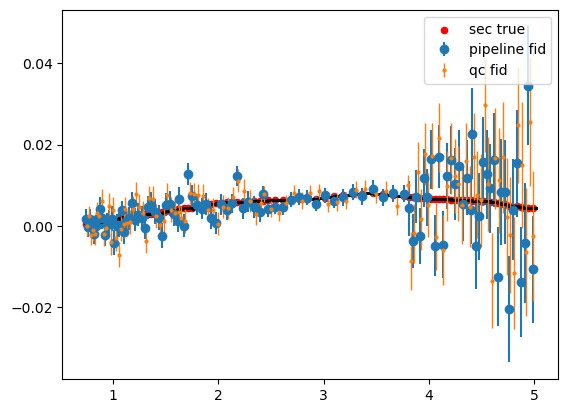

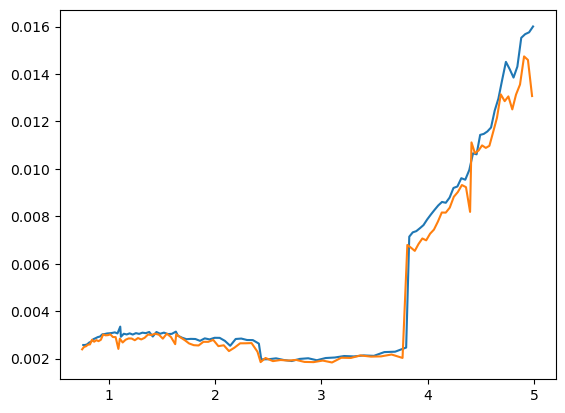

In [206]:
test = np.loadtxt("./test_fiducial.txt")
wll = np.loadtxt("./centwave.txt")
test_true = np.loadtxt("./test_fiducial_truth.txt")
plt.errorbar(wll, test[3::2]/1000, yerr=test[4::2]/1000, fmt='o', label='pipeline fid')
plt.scatter(wll, test_true[3::2], s=20, color='red', label='sec true')


### compare with the QC secondary photometry binning method
file = "../data/primary_phot_id{}_2yr.parq".format(tractorID)
print(file)
prim = Table.read(file)

file = '../data/secondary_phot_id{}_2yr.parq'.format(tractorID)
print(file)
secd = Table.read(file)

## plot photometry
# plt.errorbar(prim['lambda'][0], prim['flux'][0]/1000, yerr=prim['flux_err'][0]/1000, fmt='o', ms=2, lw=1, alpha=0.2)
plt.plot(SPHEREx_Catalog_2yr['WAVELENGTH'], Truth_Catalog_2yr['Flux'], 'o',color='black', ms=1)

plt.errorbar(secd['lambda'][0], secd['flux_deepfield'][0]/1000, yerr=secd['flux_err_deepfield'][0]/1000, 
             fmt='o', ms=2, lw=1, label='qc fid')
# plt.ylim(0, 0.004)
plt.legend()

plt.show()

plt.plot(secd['lambda'][0], secd['flux_err_deepfield'][0]/1000)
plt.plot(wll, test[4::2]/1000)


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  9.,  7.,  8.,
        16.,  9., 13.,  9., 10.,  1.,  1.,  8.,  3.,  2.,  2.]),
 array([-5.        , -4.58333333, -4.16666667, -3.75      , -3.33333333,
        -2.91666667, -2.5       , -2.08333333, -1.66666667, -1.25      ,
        -0.83333333, -0.41666667,  0.        ,  0.41666667,  0.83333333,
         1.25      ,  1.66666667,  2.08333333,  2.5       ,  2.91666667,
         3.33333333,  3.75      ,  4.16666667,  4.58333333,  5.        ]),
 [<matplotlib.patches.Polygon at 0x31e7d2750>])

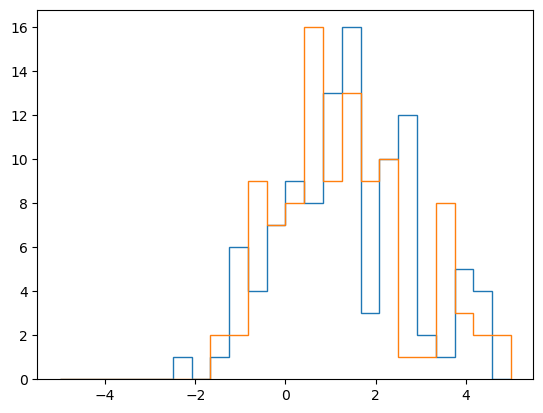

In [207]:
### plot photometric z-score:

# qc fiducial measurement
zsc_qc = (secd['flux_deepfield'][0] - test_true[3::2]) / secd['flux_err_deepfield'][0]
plt.hist(zsc_qc.flatten(), histtype='step', bins=np.linspace(-5, 5, 25))

# pipeline fiducial measurement
zsc_pipe = (test[3::2] - test_true[3::2]) / test[4::2]
plt.hist(zsc_pipe.flatten(), histtype='step', bins=np.linspace(-5, 5, 25))


In [208]:
## try save_level3_secondary()
save_level3_secondary_truth(SPHEREx_Catalog_2yr[id_primary], 
                            Channels, 
                            SPHEREx_Instrument, 
                            "./test_savelevel3_sec.parq", 
                            pointing_table=SPHEREx_Pointings.pointing_table, 
                            fluxerr_from_weights=True)


## save truth secondary catalog
spherex_truth_catalog = SPHEREx_Catalog_2yr.copy()
spherex_truth_catalog['FLUX'] = Truth_Catalog_2yr['Flux']
spherex_truth_catalog['FLUX_ERR'] = np.ones_like(spherex_truth_catalog['FLUX_ERR'])

save_level3_secondary_truth(spherex_truth_catalog[id_primary], 
                            Channels, 
                            SPHEREx_Instrument, 
                            "./test_truth_savelevel3_sec.parq", 
                            pointing_table=SPHEREx_Pointings.pointing_table, 
                            fluxerr_from_weights=True)



../data/primary_phot_id233861_2yr.parq
../data/secondary_phot_id233861_2yr.parq


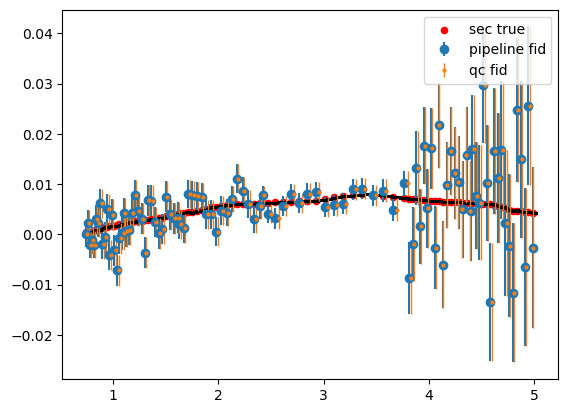

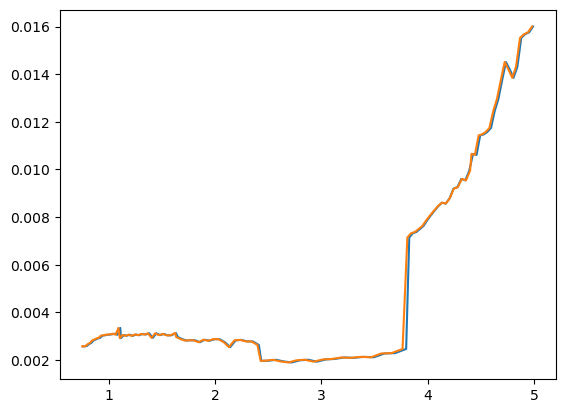

In [209]:
## check consistency 

test = Table.read("./test_savelevel3_sec.parq")
test_true = Table.read("./test_truth_savelevel3_sec.parq")
plt.errorbar(wll, test['flux_deepfield'][0]/1000, yerr=test['flux_err_deepfield'][0]/1000, 
             fmt='o', label='pipeline fid')
plt.scatter(wll, test_true['flux_deepfield'][0]/1000, s=20, color='red', label='sec true')


### compare with the QC secondary photometry binning method
file = "../data/primary_phot_id{}_2yr.parq".format(tractorID)
print(file)
prim = Table.read(file)

file = '../data/secondary_phot_id{}_2yr.parq'.format(tractorID)
print(file)
secd = Table.read(file)

## plot photometry
# plt.errorbar(prim['lambda'][0], prim['flux'][0]/1000, yerr=prim['flux_err'][0]/1000, fmt='o', ms=2, lw=1, alpha=0.2)
plt.plot(SPHEREx_Catalog_2yr['WAVELENGTH'], Truth_Catalog_2yr['Flux'], 'o',color='black', ms=1)

plt.errorbar(secd['lambda'][0], secd['flux_deepfield'][0]/1000, yerr=secd['flux_err_deepfield'][0]/1000, 
             fmt='o', ms=2, lw=1, label='qc fid')
# plt.ylim(0, 0.004)
plt.legend()

plt.show()

plt.plot(secd['lambda'][0], secd['flux_err_deepfield'][0]/1000)
plt.plot(wll, test['flux_err_deepfield'][0]/1000)



(array([ 0.,  0.,  0.,  0.,  0.,  1.,  2.,  2.,  4., 12., 16., 14.,  9.,
        17., 14.,  6.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-5.        , -4.58333333, -4.16666667, -3.75      , -3.33333333,
        -2.91666667, -2.5       , -2.08333333, -1.66666667, -1.25      ,
        -0.83333333, -0.41666667,  0.        ,  0.41666667,  0.83333333,
         1.25      ,  1.66666667,  2.08333333,  2.5       ,  2.91666667,
         3.33333333,  3.75      ,  4.16666667,  4.58333333,  5.        ]),
 [<matplotlib.patches.Polygon at 0x31efb0a90>])

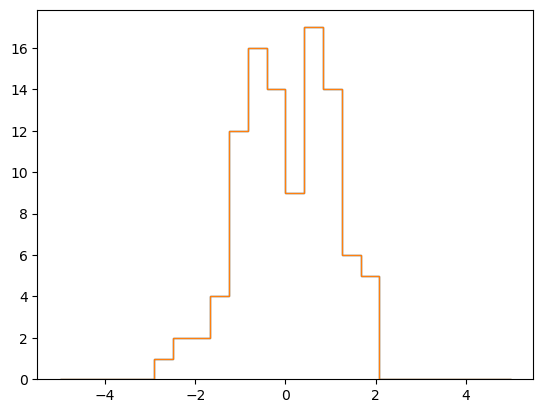

In [211]:
### plot photometric z-score:

# qc fiducial measurement
zsc_qc = (secd['flux_deepfield'][0] - test_true['flux_deepfield'][0]) / secd['flux_err_deepfield'][0]
plt.hist(zsc_qc.flatten(), histtype='step', bins=np.linspace(-5, 5, 25))

# pipeline fiducial measurement
zsc_pipe = (test['flux_deepfield'][0] - test_true['flux_deepfield'][0]) / test['flux_err_deepfield'][0]
plt.hist(zsc_pipe.flatten(), histtype='step', bins=np.linspace(-5, 5, 25))


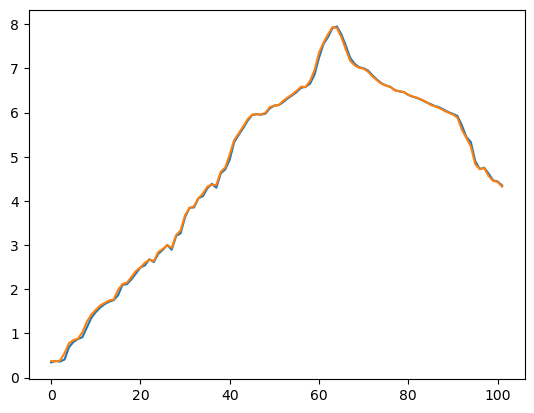

In [232]:
## compare secondary truth flux from the two functions -- well, pretty consistent... i guess not...

# pipeline measurement
test_true1 = np.loadtxt("./test_fiducial_truth.txt")
# QC measurement
test_true2 = Table.read("./test_truth_savelevel3_sec.parq")
plt.plot(test_true1[3::2] * 1000)
plt.plot(test_true2['flux_deepfield'][0])


## compare secondary photometry from the two functions
# # pipeline
# test1 = np.loadtxt("./test_fiducial.txt")
# # QC measurement
# test2 = Table.read("./test_savelevel3_sec.parq")
# ## so the error bars are slightly smaller in the pipeline measurements than QC's

# plt.hist((test1[3::2] - test_true1[3::2]) / test2['flux_err_deepfield'][0], bins=np.linspace(-5, 5, 25))
# # plt.plot(test2['flux_deepfield'][0])



In [13]:
## save L3 primary photometry, add the truth table columns: only zodi and flux
def save_level3_primary_truth(
    sim_catalog,
    output_path,
    sim_truth=None,
    pointing_table=None,
    spherex_parameters=None,
    source_id_lookup=None,
    external_survey_lookup=None,
    external_source_id_lookup=None,
    spherex_class_lookup=None,
    pm_ra=None,
    pm_dec=None,
    parallax=None,
):
    """Save `QuickCatalog` output to parquet (primary All Sky Catalog)

    Notes
    -----
    This function saves a catalog generated by
    `~SPHEREx_SkySimulator.quickcatalog.QuickCatalog` or
    `~SPHEREx_SkySimulator.quicker_catalog.QuickerCatalog` so that it looks
    like a primary All Sky Catalog in a parquet file in the format specified in
    "SSDC Data Product Specification: Level 3 All-Sky Catalog" Version 1.0
    February 13, 2023

    Parameters
    ----------
    sim_catalog : `~astropy.Table`
        A table object containing the catalog data.

    output_path : str or None
        The path and filename to write the output parquet file.
        If `None`, the function will return the pyarrow table.

    sim_truth : `~astropy.Table`, optional
        The truth catalog output by
        `~SPHEREx_SkySimulator.quickcatalog.QuickCatalog`. The zodi background
        is retrieved and included in the output parquet file.
        Default is `None`.

    pointing_table : `~astropy.Table`, optional
        Survey plan used to generate the catalog.
        Default is `None`.

    spherex_parameters : dict, optional
        A SPHEREx parameter dictionary.
        Default is `None`.

    source_id_lookup : dict, optional
        A dictionary that provides a translation between the ``"SOURCE_ID"``
        field produced by `~SPHEREx_SkySimulator.quickcatalog.QuickCatalog` and
        the output ``"source_id"``.
        Default is `None`.

    external_survey_lookup : dict, optional
        A dictionary that provides a translation between the ``"SOURCE_ID"``
        field produced by `~SPHEREx_SkySimulator.quickcatalog.QuickCatalog` and
        the output ``"external_survey"``.
        Default is `None`.

    spherex_class_lookup : dict, optional
        A dictionary that provides a translation between the ``"SOURCE_ID"``
        field produced by `~SPHEREx_SkySimulator.quickcatalog.QuickCatalog` and
        the output ``"spherex_class"``.
        Default is `None`.

        .. note::
            ``"spherex_class"`` is a bitwise flag with information about what
            the source is used for by the pipeline. ::

                    Bit Name
                    0 ASTROMETRIC
                    1 PSF
                    2 PHOTOMETRIC
                    3 CALSPEC
                    4 BRIGHT
                    5 COSMOLOGY
                    6 ICES
    pm_ra, pm_dec, parallax : float, array-like, optional
        Proper motion (ra and dec) and parallax data to include in the output
        file.
        Default is `None`.

    Returns:
        None
    """
    if not isinstance(sim_catalog, Table):
        raise TypeError("input parameter `Catalog_Table` not an astropy.Table object")

    # Define lists of types for parquet library
    lfloat64 = pa.list_(pa.float64())
    lfloat32 = pa.list_(pa.float32())
    lbool = pa.list_(pa.bool_())
    lint64 = pa.list_(pa.int64())
    lint8 = pa.list_(pa.int8())

    #
    # the scheme for the parquet file output.
    # the tuple items are name, parquet data type, units, description
    #

    pa_flds_info = [
        ("source_id", pa.int64(), None, "Unique SPHEREx ID"),
        ("external_survey", pa.int8(), None, "Identifier of external survey"),
        (
            "external_source_id",
            pa.int64(),
            None,
            "ID of source in external_survey catalog",
        ),
        ("spherex_class", pa.int32(), None, "Source origin in reference catalog"),
        ("ra", pa.float64(), u.deg, "R.A. (from reference catalog)"),
        ("dec", pa.float64(), u.deg, "Decl. (from reference catalog)"),
        (
            "pm_ra",
            pa.float32(),
            u.mas / u.yr,
            "Proper motion in R.A. (from reference catalog)",
        ),
        (
            "pm_dec",
            pa.float32(),
            u.mas / u.yr,
            "Proper motion in Decl. (from reference catalog)",
        ),
        ("parallax", pa.float32(), u.mas, "Parallax (from reference catalog)"),
        ("x_image", lfloat32, None, "X pixel position on LVF image used for fitting"),
        ("y_image", lfloat32, None, "Y pixel position on LVF image used for fitting"),
        (
            "offset_ra",
            lfloat32,
            u.mas,
            "Delta R.A. offset from reference to fit position",
        ),
        (
            "offset_dec",
            lfloat32,
            u.mas,
            "Delta Decl. offset from reference to fit position",
        ),
        ("mjd", lfloat64, u.day, "Modified Julian Date of exposure midpoint"),
        ("lambda", lfloat32, u.micron, "SPHEREx wavelength"),
        ("lambda_width", lfloat32, u.micron, "SPHEREx wavelength width"),
        ("flux", lfloat32, u.uJy, "SPHEREx observed flux"),
        ("flux_err", lfloat32, u.uJy, "SPHEREx observed flux error"),
        (
            "flux_bkg",
            lfloat32,
            u.MJy / u.sr,
            "SPHEREx background surface brightness at source position",
        ),
        ("zodi", lfloat64, u.MJy/u.steradian, "Native zodiacal light"),
        ("flux_truth", lfloat64, u.mJy, "Native truth flux, convolved with LVFs."),
        ("ext_flg", pa.bool_(), None, "True if treated as extended source"),
        ("flags", lint64, None, "Photometry flags"),
        ("fit_ql", lfloat32, None, "Photometry metric"),
        ("deep_flg", lbool, None, "True if Deep Field observation"),
        ("lvf_id", lint64, None, "ID of LVF exposure used for measurement"),
        ("det_id", lint8, None, "Detector Number"),
        ("nyquist_comp", pa.float32(), None, "Nyquist completeness"),
    ]
    pa_units = {}
    for t in pa_flds_info:
        pa_units[t[0]] = t[2]

    # these are output fields that are array-like
    list_items = (
        "x_image",
        "y_image",
        "offset_ra",
        "offset_dec",
        "mjd",
        "lambda",
        "lambda_width",
        "flux",
        "flux_err",
        "flux_bkg",
        "zodi",
        "flux_truth",
        "flags",
        "fit_ql",
        "deep_flg",
        "lvf_id",
        "det_id",
    )

    # these are output fields that are just a direct copy of the input
    direct_mapping = {
        "x_image": "X",
        "y_image": "Y",
        "flux": "FLUX",
        "flux_err": "FLUX_ERR",
        "lambda": "WAVELENGTH",
        "det_id": "DETECTOR",
        "zodi": "Zodi",
        "flux_truth": "Flux"
    }
    convert = {
        "x_image": None,
        "y_image": None,
        "flux": u.uJy,
        "flux_err": u.uJy,
        "lambda": u.micron,
        "det_id": None,
        "zodi": u.MJy/u.steradian,
        "flux_truth": u.mJy
    }

    sources = np.unique(sim_catalog["SOURCE_ID"])

    if source_id_lookup is None:
        already_registered = {uid: False for uid in sources}
        source_id_lookup = {}
        l3_indx = 0

        for row in sim_catalog:
            source_id = row["SOURCE_ID"]
            if already_registered[source_id] is True:
                continue
            source_id_lookup[source_id] = l3_indx
            l3_indx += 1
            already_registered[source_id] = True

    source_idx = np.array([source_id_lookup[i] for i in sim_catalog["SOURCE_ID"]])

    if spherex_parameters is not None:
        R = np.array(spherex_parameters["filter"]["R"]["value"])
    else:
        R = [41.2, 41.7, 41.1, 34.6, 117.1, 132.8]

    lambda_width = np.zeros_like(sim_catalog["WAVELENGTH"])
    for ii, wl in enumerate(sim_catalog["WAVELENGTH"]):
        lambda_width[ii] = wl / R[sim_catalog["DETECTOR"][ii] - 1]

    if sim_truth is not None:
        background = sim_truth["Zodi"].data
    else:
        background = np.zeros_like(sim_catalog["WAVELENGTH"])

    rows = []
    unique_src_idx, idx = np.unique(source_idx, return_index=True)

    # loop over sources
    for isrc in unique_src_idx[np.argsort(idx)]:

        # assemble the row in the All Sky Catalog
        row = {}

        # start with data that is just one value per row
        row["source_id"] = isrc

        if external_survey_lookup is not None:
            row["external_survey"] = external_survey_lookup[isrc]
        else:
            row["external_survey"] = 0

        if external_source_id_lookup is not None:
            row["external_source_id"] = external_source_id_lookup[isrc]
        else:
            row["external_source_id"] = 0

        # assign appropriate spherex_class for cosmology and ices:
        # Bit Name
        #   0 ASTROMETRIC
        #   1 PSF
        #   2 PHOTOMETRIC
        #   3 CALSPEC
        #   4 BRIGHT
        #   5 COSMOLOGY
        #   6 ICES
        if spherex_class_lookup is not None:
            row["spherex_class"] = spherex_class_lookup[isrc]
        else:
            row["spherex_class"] = 0

        row["pm_ra"] = pm_ra or 0.0
        row["pm_dec"] = pm_dec or 0.0
        row["parallax"] = parallax or 0.0
        row["ext_flg"] = False

        # now do rows that contain lists of data

        # pick out rows containing this source
        i = source_idx == isrc
        source_bg = background[i]
        source_lambda_width = lambda_width[i]
        mean_ra = np.average(sim_catalog["RA"][i])
        mean_dec = np.average(sim_catalog["DEC"][i])

        row["nyquist_comp"] = (len(source_bg) >= 2 * 105) * 1.0

        row["ra"] = mean_ra
        row["dec"] = mean_dec

        for col in list_items:
            row[col] = []

        # loop over observations of the given source
        for ii, input_row in enumerate(sim_catalog[i]):
            # get data that is just a one-to-one map
            # and convert units
            for col in direct_mapping.keys():
                value = input_row[direct_mapping[col]]
                if convert[col] is not None:
                    if not hasattr(value, "unit"):
                        value <<= sim_catalog[direct_mapping[col]].unit
                    value = value.to_value(pa_units[col])

                row[col].append(value)

            row["lvf_id"].append(input_row["IMAGE_ID"] * 10 + input_row["DETECTOR"])
            # convert to Modified Julian Date
            row["mjd"].append(input_row["JD"] - 2400000.5)

            # do we have the background data from the truth catalog?
            if sim_truth is not None:
                row["flux_bkg"].append(source_bg[ii])
            else:
                row["flux_bkg"].append(0.0)

            row["offset_ra"].append(mean_ra - input_row["RA"])
            row["offset_dec"].append(mean_dec - input_row["DEC"])

            row["lambda_width"].append(source_lambda_width[ii])

            in_deep = False
            if pointing_table is not None:
                in_deep = pointing_table[input_row["IMAGE_ID"]]["Flag"] in [
                    "deep_north",
                    "deep_south",
                ]

            row["deep_flg"].append(in_deep)

            row["flags"].append(0)
            row["fit_ql"].append(1)

        rows.append(row)

    # function to create field with metadata
    def create_pa_fld(name, pa_type, unit, descr):
        # all columns should have description
        fld_metadata = {"description": descr}
        if unit is not None:
            fld_metadata["unit"] = str(unit)
        return pa.field(name, pa_type, metadata=fld_metadata)

    schema = pa.schema([create_pa_fld(t[0], t[1], t[2], t[3]) for t in pa_flds_info])

    # Create pyarrow table with schema and rows
    allsky_cat = pa.Table.from_pylist(rows, schema=schema)

    if output_path is None:  # Do not save file but return pyarrow table
        return allsky_cat

    with parquet.ParquetWriter(output_path, schema=allsky_cat.schema) as writer:
        writer.write_table(allsky_cat)

    return

In [182]:
## test

# append Truth catalog to SPHEREx catalog
# spherex_truth_catalog.add_column(Truth_Catalog_2yr['Zodi'], name='Zodi')
spherex_truth_catalog.add_column(Truth_Catalog_2yr['Flux'], name='Flux')



In [184]:
save_level3_primary_truth(spherex_truth_catalog[id_primary], 
                          './test_saveprimary.parq')


In [185]:
dd = Table.read("./test_saveprimary.parq")

In [187]:
# compute secondary photometry
## try save_level3_secondary()
save_level3_secondary_truth(spherex_truth_catalog[id_primary], 
                            Channels, 
                            SPHEREx_Instrument, 
                            "./test_savelevel3_sec_reload.parq", 
                            pointing_table=SPHEREx_Pointings.pointing_table, 
                            fluxerr_from_weights=True)


## save truth secondary catalog
spherex_truth_catalog = SPHEREx_Catalog_2yr.copy()
spherex_truth_catalog['FLUX'] = Truth_Catalog_2yr['Flux']
spherex_truth_catalog['FLUX_ERR'] = np.ones_like(spherex_truth_catalog['FLUX_ERR'])

save_level3_secondary_truth(spherex_truth_catalog[id_primary], 
                            Channels, 
                            SPHEREx_Instrument, 
                            "./test_truth_savelevel3_sec.parq", 
                            pointing_table=SPHEREx_Pointings.pointing_table, 
                            fluxerr_from_weights=True)



In [68]:
### well, try directly saving the SPHEREx Catalog for secondary photometry calculation...

## add Truth Catalog table
SPHEREx_Catalog_2yr.add_column(Truth_Catalog_2yr['Zodi'], name='Zodi')
SPHEREx_Catalog_2yr.add_column(Truth_Catalog_2yr['Flux'], name='Flux')

In [69]:
## or just fits file
SPHEREx_Catalog_2yr.write("./QC_output.fits", format='fits', overwrite=True)

In [70]:
dd = Table.read("./QC_output.fits", format='fits')

In [71]:
save_level3_secondary_truth(dd, 
                            Channels, 
                            SPHEREx_Instrument, 
                            "./test_savelevel3_sec.parq", 
                            pointing_table=SPHEREx_Pointings.pointing_table, 
                            fluxerr_from_weights=True)


In [72]:
tt = Table.read("./test_savelevel3_sec.parq")

# Flux error scaling & secondary photometry binning; downstream processing

1. Find all primary photometry files
2. For each:
    * calculate original secondary with save_level3_secondary(), and save flux errors
    * modify flux, fluxerr cols in the primary table to compute secondary truth flux save_level3_secondary_truth()
    * scale error bars from the first bullet points to 2-year survey
    * inject Gaussian noise into binned truth flux using the scaled error bars
    * output scaled secondary photometry into a combined txt file passed onto photo-z


gotta deal with nan values in flux errors

## On TACC: generate a combined secondary photometry file with scaled error bars

In [205]:
def write_output_to_photoz(flux, flux_err, source_id, ra, dec, filename, NewFile=False):
    
    """
    For a given source,
    flux, flux_err = 1D arrays of floats, ideally in spherex 102 fiducial bands, match Photoz input filters. [mJy]
    source_id = int, source ID as the first column
    filename = output filename
    NewFile = True/False: if True, create a new file; if False, append a line to the given file.
    ---------
    Returns: nothing
    """
    
    spectrum = list(itertools.chain(*zip(flux, flux_err))) # in mJy
    # insert ID, ra, dec
    spectrum.insert(0, dec) 
    spectrum.insert(0, ra)
    spectrum.insert(0, int(source_id))
    
    if NewFile == False:
        # open the existing file and append a line of spectrum. 
        with open(filename, "a") as f:
            f.write("\n" + " ".join(map(str, spectrum)))
            
    else:
        # create a new file and write the first line
        with open(filename, "w") as f:
            f.write(" ".join(map(str, spectrum)))
    
    return 




In [206]:

### find all primary photometry parquet files

directory = '/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/QCoutput/'
name = 'primary_phot' # files starting with 'primary' 
 
files = os.listdir(directory)
 
# sort files based on their id
filenames = [filename for filename in files if filename.startswith(name)]
files_sorted = sorted(filenames, key=lambda x: int(x.split('id')[-1].split('.fits')[0]))

print(len(files_sorted))


10


In [209]:
### for each, calculate original secondary photometry, save flux errors

## output directory
secondary_dir = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/blended_QC/"
ra_colname = 'ra_allsky'
dec_colname = 'dec_allsky'
output_filename = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/QCoutput/secondary_phot_combined_noAri.txt"
plot = False


## Z-score calculation later
F_2yr = []
F_truth = []
Fe_scaled = []

count = 0
for f in range(len(files_sorted)):
    
    # QC primary photometry catalog,
    prim_cat = Table.read(directory + files_sorted[f])

    # compute secondary photometry, using internal filter sets
    save_level3_secondary_truth(prim_cat, 
                                Channels, 
                                SPHEREx_Instrument, 
                                secondary_dir+"secondary_inter.parq", 
                                pointing_table=SPHEREx_Pointings.pointing_table, 
                                fluxerr_from_weights=True)


    ## save truth secondary catalog
    prim_cat['FLUX'] = prim_cat['Flux'] # replace the measured primary photometry with true flux
    prim_cat['FLUX_ERR'] = np.ones_like(prim_cat['FLUX_ERR']) # constant flux err, doesn't matter here

    SPsky.save_level3_secondary(prim_cat, 
                                Channels, 
                                SPHEREx_Instrument, 
                                secondary_dir+"secondary_inter_truth.parq", 
                                pointing_table=SPHEREx_Pointings.pointing_table, 
                                fluxerr_from_weights=True)


    ## read in the secondary photometry
    sec_tbl = Table.read(secondary_dir+'secondary_inter.parq', format="parquet")

    ## read in the secondary truth photometry
    sec_truth = Table.read(secondary_dir+'secondary_inter_truth.parq', format="parquet")

    # save secondary (full sky / deep field)
    if ra_colname.endswith('_deep'):
        flux_colname = 'flux_deepfield'
        flux_err_colname = 'flux_err_deepfield'
    else:
        flux_colname = 'flux_allsky'
        flux_err_colname = 'flux_err_allsky'

    # original secondary error bars
    fe_og = sec_tbl[flux_err_colname][0] / 1000 # mJy
    # truth secondary photometry
    f_truth = sec_truth[flux_colname][0] / 1000 # mJy

    # well if there's singular matrix non-invertible, put nan everywhere...
    if False in np.isfinite(fe_og):
        ## skip this source!!
        fe_og = np.nan + np.zeros_like(fe_og)
        continue


    # delete the intermediate file
    try:
        os.remove(secondary_dir + 'secondary_inter.parq')
        os.remove(secondary_dir + 'secondary_inter_truth.parq')
    except FileNotFoundError:
        print("File " + secondary_dir + 'secondary_inter.parq ' +  "not found.")

    ## Modify error bars
    scaling = np.sqrt(24 / 3) # for the 3 month survey plan
    fe_scaled = fe_og / scaling

    ## Inject Gaussian noise into truth photometry
    noise = np.random.normal(0, 1, size=f_truth.shape) * fe_scaled
    f_2yr = f_truth + noise
    
    ## append to the z-score calculation
    F_2yr.append(f_2yr)
    F_truth.append(f_truth)
    Fe_scaled.append(fe_scaled)
    
    ## plot scaled error bars
    if plot is True:
        plt.figure(figsize=(5,4))
        plt.plot(wl, fe_og)
        plt.plot(wl, fe_scaled)
        plt.show()
    
    
    ## append this spectrum to an output file for photo-z run
    # need write_output_to_photoz(flux, flux_err, source_id, filename, NewFile=False)
    source_id = int(files_sorted[f].split("id")[-1].split(".fits")[0])
    ra = prim_cat['RA'][0]
    dec = prim_cat['DEC'][0]
    write_output_to_photoz(flux=f_2yr,
                           flux_err=fe_scaled,
                           source_id=source_id,
                           ra=ra,
                           dec=dec,
                           filename=output_filename,
                           NewFile=(count==0))


    count += 1
    

F_2yr = np.array(F_2yr)
F_truth = np.array(F_truth)
Fe_scaled = np.array(Fe_scaled)




Text(0.5, 0, 'Scaled photometric z-score')

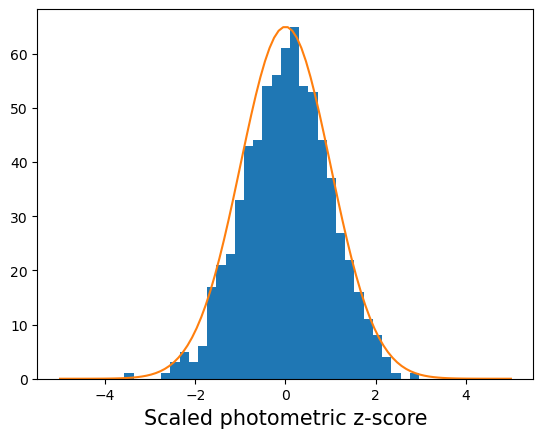

In [210]:
## compute z-score
# zsc_2yr = (f_2yr - f_truth) / fe_scaled
Zsc_2yr = (F_2yr.flatten() - F_truth.flatten()) / Fe_scaled.flatten()
hist = plt.hist(Zsc_2yr, bins=np.linspace(-5,5,50))[0]

# plot Gaussian 
def Gaussian(x, A, sig, x0):
    g = A * np.exp(-(x-x0)**2 / (2*sig**2))
    return g

xx = np.linspace(-5, 5, 100)
plt.plot(xx, Gaussian(xx, hist.max(), 1, 0))
plt.xlabel("Scaled photometric z-score", fontsize=15)


## Local: confusion injection & Photo-z

### Compare confusion library

(297, 207)


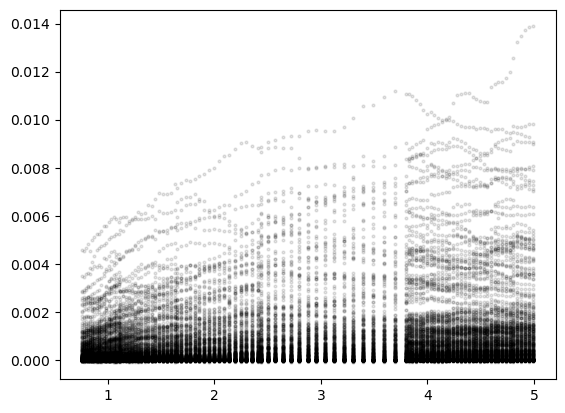

In [214]:
sys.path.append(os.path.abspath("../scripts"))
from confusion_lib_build import ConfusionLibrary as cl
cosmos = Table.read("../../../../SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits", format='fits')


contour = 0.4
lib_04_path = f"/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/confusion_lib/confusion_lib_contour{contour}.txt"
lib_04 = np.loadtxt(lib_04_path)
print(lib_04.shape)
for l in range(lib_04.shape[0]):
    plt.errorbar(wl, lib_04[l][3::2], yerr=lib_04[l][4::2],  fmt='o', ms=2, color='black', alpha=0.1)


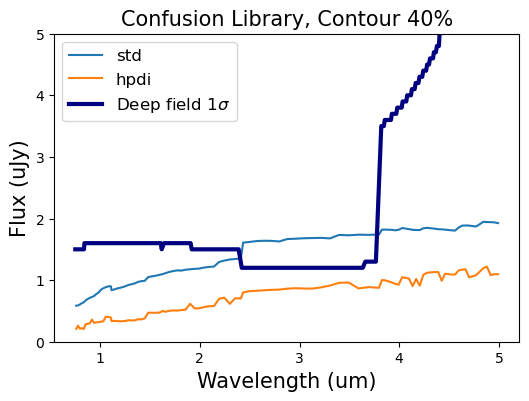

In [240]:
idx_refcat = np.loadtxt(f"../../data/refcat_cuts/boolean_cut_{contour}.txt")

clib = cl(Pointings = SPHEREx_Pointings,
          Instrument = SPHEREx_Instrument,
          Scene = Scene, 
          Channels = Channels, 
          catalog = cosmos, 
          ra_colname = "ALPHA_J2000",
          dec_colname = "DELTA_J2000",
          id_colname = "Tractor_ID",
          idx_refcat = idx_refcat,
)
(std, mean, hpdi) = clib.calc_lib_variation(lib_04_path, 90)

fig = plt.figure(figsize=(6,4))
plt.plot(wl, np.array(std)*1000, label='std')
# plt.plot(wl, np.array(mean)*1000, label='mean')
plt.plot(wl, np.array(hpdi)*1000, label='hpdi')
plt.legend(fontsize=12, loc='lower right')
plt.xlabel("Wavelength (um)", fontsize=15)
plt.ylabel("Flux (uJy)", fontsize=15)
plt.title(f"Confusion Library, Contour {int(contour*100)}%", fontsize=15)

## plot the sensitivity curve
data = pd.read_csv('/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx_2023/Codes/intensity_mapper_v30.csv')
band = np.array([1,2,3,4,5,6])
idx_s = (band-1)*3 + 1
idx_d = (band-1)*5 + 3

ww = np.array([])
spec_shallow = np.array([])
spec_deep = np.array([])
for i in range(len(band)):
    name = "Band {}.1".format(band[i])
    ww = np.append(ww, data[name][3:66].to_numpy().astype(float))
    name = "shallow.{}".format(idx_s[i])
    spec_shallow = np.append(spec_shallow, data[name][3:66].to_numpy().astype(float))
    name = "deep.{}".format(idx_d[i])
    spec_deep = np.append(spec_deep, data[name][3:66].to_numpy().astype(float))

plt.plot(ww, spec_deep, color='navy', lw=3, label=r'Deep field 1$\sigma$')
#plt.yscale("log")
plt.ylim(0, 5)
plt.legend(fontsize=12)
